# LBM Step 1: Image Assembly

Raw ScanImage .tiff files are saved to disk in an interleaved manner.

## Steps:

**1a.** Set up filepaths.

**1b.** Extract ScanImage metadata.

**1c.** Use metadata to de-interleave frames into planar timeseries.

**1d.** Correct Bi-Directional Offset for each ROI.

## To read our data, we will use the [scanreader](https://github.com/atlab/scanreader/tree/master).

scanreader is a `.tiff` reader (wrapped around [tifffile](https://pypi.org/project/tifffile/)) that extracts ScanImage specific metadata used to horizontally concatenate each ROI.

This reader loads data **lazily**, that is, only when data needs to be loaded into memory and thus allows us to preview small [`chunks`](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes#what-are-dask-array-chunks) our image before performing computations on the entire dataset.

In [24]:
## Imports
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import numpy as np
import tifffile
import zarr

import fastplotlib as fpl

# Importing this WONT WORK without adding to the path
sys.path.append('../..')  # TODO: Take this out when we upload to pypi

import matplotlib.pyplot as plt

# MBO Repositories
import scanreader as sr
import lbm_caiman_python as lcp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Input data: Path to your raw .tiff file(s)

Before processing, ensure:
- Put all raw `.tiff` files, from a single imaging session, into a directory. 
    - Here, we name that directory `raw`
- No other `.tiff` files reside in this directory

There are a few ways to pass your raw files into the scanreader.

1) A string containing a wildcard pattern for files to gather:
2) A list of strings containing all files in that directory.

## 1) A string containing a wildcard pattern for files to gather

In [2]:
files = "C:/Users/RBO/caiman_data/raw/*.tiff"
scan = sr.read_scan(files, join_contiguous=True)
scan.num_channels

30

## 2) A list of strings containing all files in that directory

In [3]:
# 2) A list of strings containing all files in that directory
parent_dir = Path().home() / 'caiman_data' / 'raw'

# gather a list of all tiff files in our parent_dir
raw_tiff_files = [str(x) for x in parent_dir.glob("*.tif*")]
raw_tiff_files

['C:\\Users\\RBO\\caiman_data\\raw\\high_res_full.tiff']

In [4]:
scan = sr.read_scan(raw_tiff_files, join_contiguous=True)
print(f'Planes: {scan.num_channels}')
print(f'Frames: {scan.num_frames}')
print(f'ROIs: {scan.num_rois}')
print(f'Fields: {scan.num_fields}')

Planes: 30
Frames: 1730
ROIs: 4
Fields: 1


Because `join_contiguous=True`, we only have 1 field as each of the 4 ROI's were joined.

In [5]:
array = scan[:, :, :, 0, -500:]
array.shape

(1, 600, 576, 500)

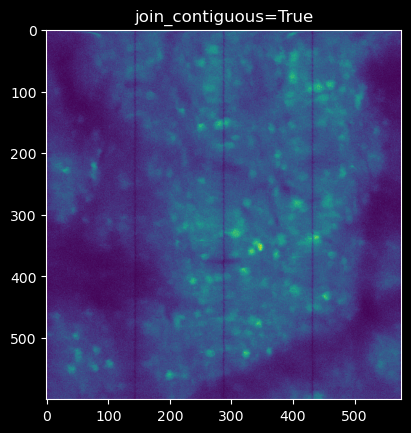

In [6]:
%matplotlib inline

plt.imshow(array[0, :, :, 0])
plt.title('join_contiguous=True')
plt.show()

Now with `join_contiguous=False`, ROI's are **not** joined to form a contiguous field, instead we have 4 separated ROIs which can be saved.

In [7]:
scan = sr.read_scan(raw_tiff_files, join_contiguous=False)
print(f'Planes: {scan.num_channels}')
print(f'Frames: {scan.num_frames}')
print(f'ROIs: {scan.num_rois}')
print(f'Fields: {scan.num_fields}')

Planes: 30
Frames: 1730
ROIs: 4
Fields: 4


In [14]:
array = scan[:, :, :, 0, -500:]
array.shape

(4, 600, 144, 500)

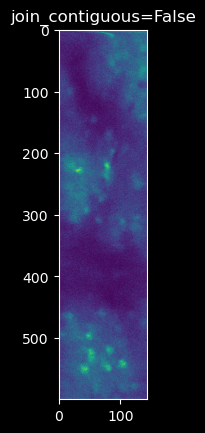

In [15]:
%matplotlib inline

plt.imshow(array[0, :, :, 0])
plt.title('join_contiguous=False')
plt.show()

In [18]:
array.shape

(4, 600, 144, 500)

## Note on data shape/order

- scanreader outputs data in `[y, x, T]`, but most image processing tools require data in `[T, y, x]`
- we need to flip the array

In [19]:
roi = array[0, ...]
roi.shape

(600, 144, 500)

In [20]:
roi_t = np.transpose(roi, (2, 0, 1))

image_widget = fpl.ImageWidget(roi_t, histogram_widget=False)
image_widget.show()

RFBOutputContext()

JupyterOutputContext(children=(JupyterWgpuCanvas(), IpywidgetToolBar(children=(Button(icon='expand-arrows-alt'…

In [21]:
image_widget.close()

## Path to save your files

Note for zarr files to be compatible with caiman we need to control the filenames.

Each z-plane sent through caiman needs a .zarr extension, and to be further compatible with caiman locating the dataset we need to further add a 'mov' subdirectory to mimic compatibility hdf5 groups.

This is a CaImAn specific quirk, and we suggest sticking with `.tiff` to avoid any future incompatibilities with CaImAn updates.

In [26]:
# For .tiff files
save_path = parent_dir / 'out'
save_path.mkdir(exist_ok=True)
save_path

WindowsPath('C:/Users/RBO/caiman_data/raw/out')

We pass our scan object, along with the save path into `lbm_caiman_python.save_as()`

- if join_contiguous=True, the assembled image will be saved
- if join_contiguous=False, each ROI will be saved

In [27]:
lcp.save_as(scan, save_path)

Planes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


KeyboardInterrupt: 